# Augmentation Gallery

This example showcases different augmentations possible with DALI.

In [1]:
from __future__ import division
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.ops as ops
import nvidia.dali.types as types
import numpy as np
from timeit import default_timer as timer
import numpy as np
import matplotlib.pyplot as plt
import math
import os.path

test_data_root = os.environ['DALI_EXTRA_PATH']
db_folder = os.path.join(test_data_root, 'db', 'lmdb')

class HybridPipe(Pipeline):
    def __init__(self, batch_size, num_threads, device_id, pipelined = True, exec_async = True):
        super(HybridPipe, self).__init__(batch_size, num_threads, device_id, seed = 12, exec_pipelined=pipelined, exec_async=exec_async)
        self.input = ops.CaffeReader(path = db_folder, random_shuffle = True)
        self.decode = ops.ImageDecoder(device = "mixed", output_type = types.RGB)
        self.augmentations = {}
        # input is sampled randomly for output pixel's neighbourhood
        self.augmentations["jitter"] = ops.Jitter(device = "gpu")
        # transforms sampling coordinates to produce wavy patterns
        self.augmentations["water"] = ops.Water(device = "gpu")
        # applies fisheye distortion
        self.augmentations["shpere"] = ops.Sphere(device = "gpu")
        # rotates the image, enlarging the canvas
        self.augmentations["rotate"] = ops.Rotate(device = "gpu", angle = 30, interp_type = types.INTERP_LINEAR, fill_value = 0)
        # applies affine transform
        self.augmentations["warpaffine"] = ops.WarpAffine(device = "gpu", matrix = [1.0, 0.8, 0.0, 0.0, 1.2, 0.0],
                                                 interp_type = types.INTERP_LINEAR) 
        # multiplies contrast
        self.augmentations["contrast"] = ops.Contrast(device = "gpu", contrast = 1.5)
        # shifts intensity values
        self.augmentations["brightness"] = ops.Brightness(device = "gpu", brightness = 0.5)
        # multiplies saturation
        self.augmentations["saturation"] = ops.Saturation(device = "gpu", saturation = 0.2)
        # twists the hue by given value, in degrees
        self.augmentations["hue"] = ops.Hue(device = "gpu", hue = 45.)
        # places the image on a larger canvas
        self.augmentations["paste"] = ops.Paste(device = "gpu", ratio = 2., fill_value = (55, 155, 155),
                                            paste_x = .1, paste_y = .7)
        # param resizes the image so that the shorter edge is exactly 400px long
        self.augmentations["resize"] = ops.Resize(device = "gpu", resize_shorter = 480)
        # param flips the image 
        self.augmentations["flip"] = ops.Flip(device = "gpu", vertical = 1, horizontal = 0)
        self.uniform = ops.Uniform(range = (0.0, 1.0))
        self.iter = 0

    def define_graph(self):
        self.jpegs, self.labels = self.input()
        images = self.decode(self.jpegs)
        n = len(self.augmentations)
        outputs = [images for _ in range(n+1)]
        aug_list = list(self.augmentations.values())
        # outputs[0] is the original cropped image
        for i in range(n):
            outputs[i+1] = aug_list[i](outputs[i+1])
        return [self.labels] + outputs

    def iter_setup(self):
        pass

In [2]:
batch_size = 32

pipe = HybridPipe(batch_size=batch_size, num_threads=2, device_id = 0)
pipe.build()

In [3]:
pipe_out = pipe.run()

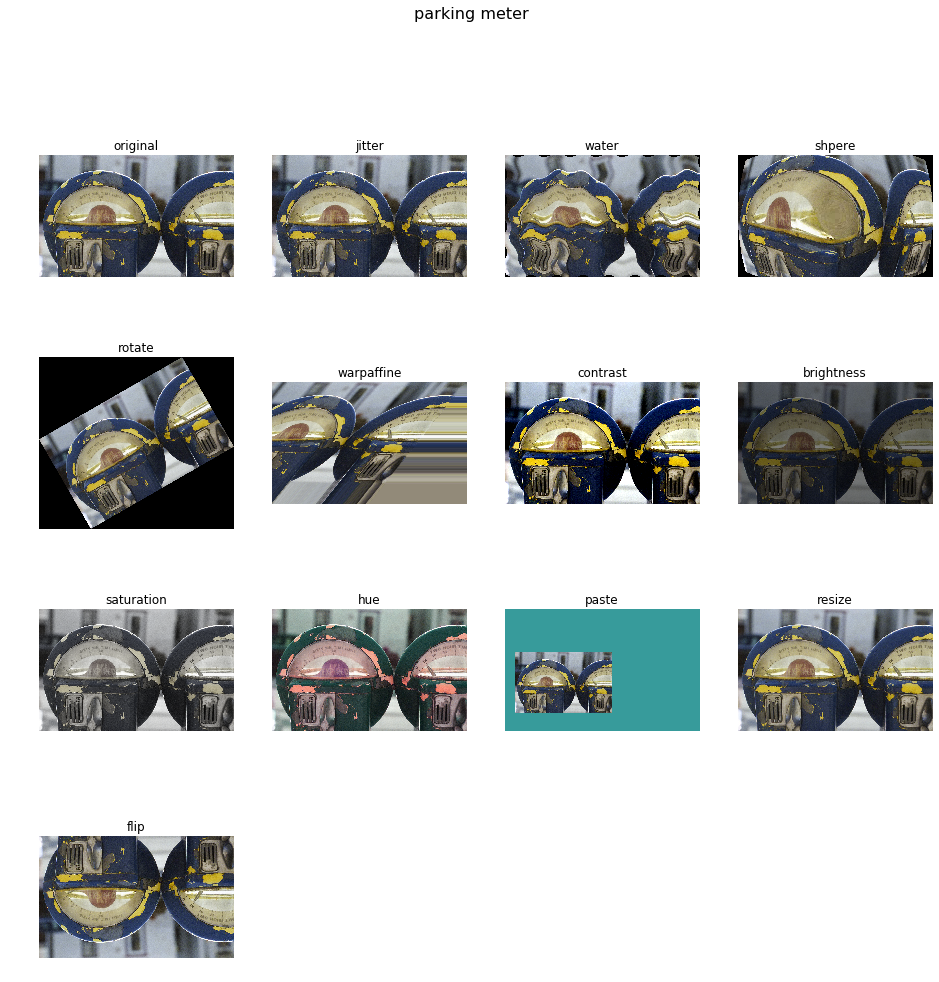

In [4]:
n = 5
from synsets import imagenet_synsets
import matplotlib.gridspec as gridspec
len_outputs = len(pipe_out) - 1
augmentations = ["original"] + list(pipe.augmentations.keys())
fig = plt.figure(figsize = (16,16))
plt.suptitle(imagenet_synsets[pipe_out[0].at(n)[0]], fontsize=16)
columns = 4
rows = int(math.ceil(len_outputs / columns))
gs = gridspec.GridSpec(rows, columns)
for i in range(len_outputs):
    plt.subplot(gs[i])
    plt.axis("off")
    plt.title(augmentations[i])
    pipe_out_cpu = pipe_out[1 + i].as_cpu()
    img_chw = pipe_out_cpu.at(n)
    plt.imshow((img_chw)/255.0)